# LSTM (Long Short Term Memories)
For Alnus only

## Libraries required

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import model_from_json

/Users/bruno.wozniak/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load the data

In [2]:
pol_wu_df = read_csv('../analyze/pollen_weather.csv')
pol_wu_df = pol_wu_df[['Date','Alnus','DayOfYear','TempMax','HumidMin','VisibilityAvg']]
pol_wu_df.set_index('Date',inplace=True)
pol_wu_df.head(5)

,Alnus,DayOfYear,TempMax,HumidMin,VisibilityAvg
Date,,,,,
1996-07-01,0.0,183,17.0,45.0,9.0
1996-07-02,0.0,184,14.0,67.0,10.0
1996-07-03,0.0,185,22.0,38.0,10.0
1996-07-04,0.0,186,19.0,60.0,8.0
1996-07-05,0.0,187,17.0,82.0,9.0


## A function to "lag" the data

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## "Lag" the data

In [4]:
values = pol_wu_df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# How many days to lag + how many features
n_days = 7
n_features = 4
# frame as supervised learning
reframed = series_to_supervised(scaled, n_days, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6,7,8,9]], axis=1, inplace=True)
print(reframed.head())

    var1(t-7)  var2(t-7)  var3(t-7)  var4(t-7)  var5(t-7)  var1(t-6)  \
7         0.0   0.498630   0.583333   0.375000   0.333333        0.0   
8         0.0   0.501370   0.520833   0.625000   0.370370        0.0   
9         0.0   0.504110   0.687500   0.295455   0.370370        0.0   
10        0.0   0.506849   0.625000   0.545455   0.296296        0.0   
11        0.0   0.509589   0.583333   0.795455   0.333333        0.0   

    var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)    ...     var1(t-1)  \
7         0.0   0.504110   0.687500   0.295455    ...           0.0   
8         0.0   0.506849   0.625000   0.545455    ...           0.0   
9         0.0   0.509589   0.583333   0.795455    ...           0.0   
10        0.0   0.512329   0.541667   0.534091    ...           0.0   
11        0.0   0.515069   0.583333   0.454545    ...           0.0   

    var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var1(t)   var2(t)   var3(t)  \
7    0.515069   0.583333   0.454545   0.370370      0.0  0.51

In [5]:
# split into train and test sets
values = reframed.values
n_train_days = 18*365
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6570, 7, 4) (6570,) (1220, 7, 4) (1220,)


Train on 6570 samples, validate on 1220 samples
Epoch 1/100
 - 1s - loss: 0.3269 - val_loss: 0.2037
Epoch 2/100
 - 0s - loss: 0.1812 - val_loss: 0.1881
Epoch 3/100
 - 0s - loss: 0.1604 - val_loss: 0.1607
Epoch 4/100
 - 0s - loss: 0.1202 - val_loss: 0.1049
Epoch 5/100
 - 0s - loss: 0.0825 - val_loss: 0.0841
Epoch 6/100
 - 0s - loss: 0.0691 - val_loss: 0.0720
Epoch 7/100
 - 0s - loss: 0.0620 - val_loss: 0.0662
Epoch 8/100
 - 0s - loss: 0.0595 - val_loss: 0.0636
Epoch 9/100
 - 0s - loss: 0.0584 - val_loss: 0.0621
Epoch 10/100
 - 0s - loss: 0.0578 - val_loss: 0.0628
Epoch 11/100
 - 0s - loss: 0.0574 - val_loss: 0.0600
Epoch 12/100
 - 0s - loss: 0.0549 - val_loss: 0.0571
Epoch 13/100
 - 0s - loss: 0.0513 - val_loss: 0.0555
Epoch 14/100
 - 0s - loss: 0.0504 - val_loss: 0.0536
Epoch 15/100
 - 0s - loss: 0.0485 - val_loss: 0.0513
Epoch 16/100
 - 0s - loss: 0.0461 - val_loss: 0.0489
Epoch 17/100
 - 0s - loss: 0.0438 - val_loss: 0.0466
Epoch 18/100
 - 0s - loss: 0.0415 - val_loss: 0.0443
Epoch 1

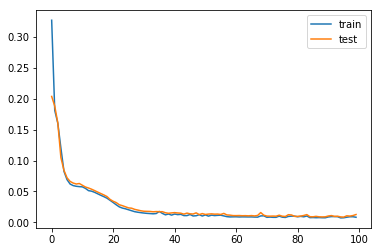

In [6]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=365, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -4:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("LSTM_model.h5")

In [10]:
data_for_predict = read_csv('weather_today_for_LSTM.csv')
data_for_predict = data_for_predict[['Date','Alnus','DayOfYear','TempMax','HumidMin','VisibilityAvg']]
data_for_predict.set_index('Date',inplace=True)

n_days = 7
n_features = 4
n_obs = n_days * n_features

# frame as supervised learning
reframed_for_predict = series_to_supervised(data_for_predict, n_days, 1)
# drop columns we don't want to predict
reframed_for_predict.drop(reframed_for_predict.columns[[6,7,8,9]], axis=1, inplace=True)
# split into train and test sets
values_for_predict = reframed_for_predict.values
# split into input and outputs
to_predict_X, to_predict_y = values_for_predict[:, :n_obs], values_for_predict[:, -n_features]
# reshape input to be 3D [samples, timesteps, features]
to_predict_X = to_predict_X.reshape((to_predict_X.shape[0], n_days, n_features))

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("LSTM_model.h5")

# make a prediction
result = loaded_model.predict(to_predict_X)

In [11]:
list(result[0])[0]

5.451121